<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practice/Practicing_Transfer_Learning_Horses_vs_Humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the Dataset**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-09-23 17:40:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   143MB/s    in 1.0s    

2020-09-23 17:40:08 (143 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-09-23 17:40:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

# **2. Verifying the Dataset Images**

In [2]:
import os
import zipfile

zip_local = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_local, 'r')

zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

zip_local = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(zip_local, 'r')

zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [3]:
train_dir = '/tmp/horse-or-human'
valid_dir = '/tmp/validation-horse-or-human'

train_horse_dir = os.path.join(train_dir, 'horses')
train_human_dir = os.path.join(train_dir, 'humans')

valid_horse_dir = os.path.join(valid_dir, 'horses')
valid_human_dir = os.path.join(valid_dir, 'humans')

train_human_fnames = os.listdir(train_human_dir)
train_horse_fnames = os.listdir(train_horse_dir)

valid_human_fnames = os.listdir(valid_human_dir)
valid_horse_fnames = os.listdir(valid_horse_dir)

print("no of training horse images : {}".format(len(train_horse_fnames)))
print("no of training human images : {}".format(len(train_human_fnames)))

print("no of validation horse images : {}".format(len(valid_horse_fnames)))
print("no of validation human images : {}".format(len(valid_human_fnames)))

no of training horse images : 500
no of training human images : 527
no of validation horse images : 128
no of validation human images : 128


# **3. Visualizing the Images in Dataset**

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

index = 0 
n_rows = 4
n_cols = 4

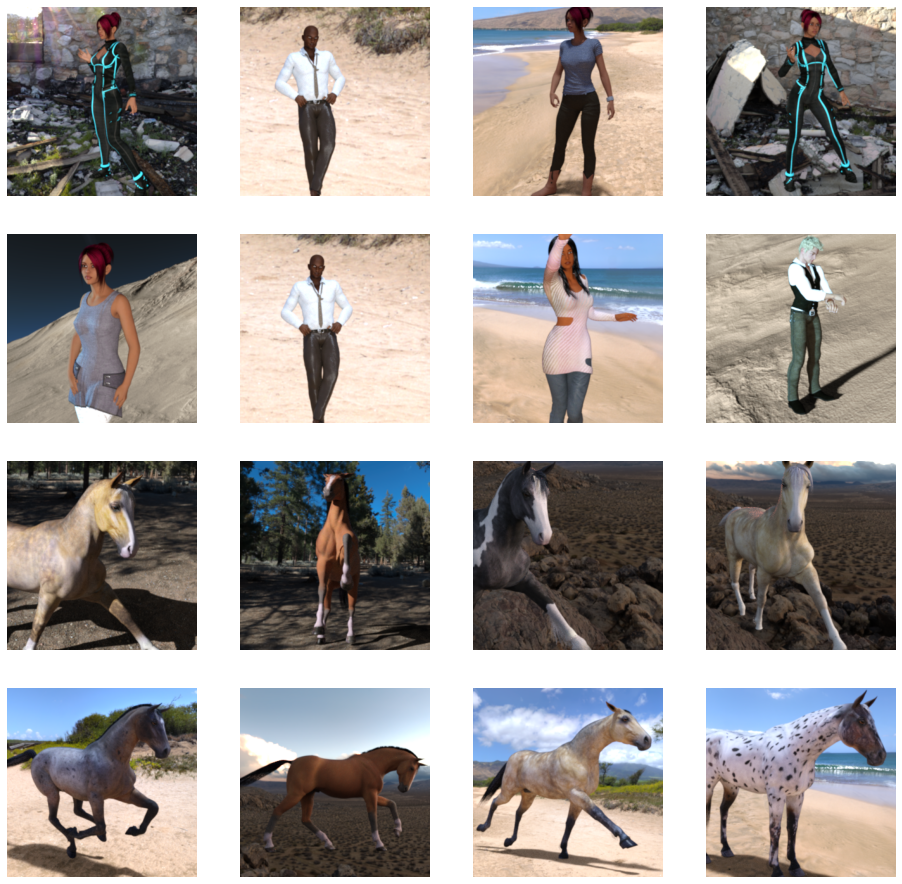

In [7]:
fig = plt.gcf()
fig.set_size_inches(n_rows*4, n_cols*4)

index += 8

human_files = [os.path.join(train_human_dir, fname) for fname in train_human_fnames[index-8: index]]
horse_files = [os.path.join(train_horse_dir, fname) for fname in train_horse_fnames[index-8: index]]

for i, image in enumerate(human_files + horse_files):
    sp = plt.subplot(n_rows, n_cols, i+1)
    sp.axis("off")

    img = mpimg.imread(image)
    plt.imshow(img)

plt.show()

# **4. Data Preprocessing**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="binary"
)

valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    batch_size=16,
    target_size=(224, 224),
    class_mode="binary"
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# **5. Using Transfer Learning to make a model**

In [25]:
base_model = keras.applications.VGG19(include_top=False,
                                      weights="imagenet",
                                      input_shape=(224, 224, 3))

flatten_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(128, activation="relu")(flatten_layer)
output = keras.layers.Dense(1, activation="sigmoid")(dense_layer)

model = keras.Model(inputs=[base_model.input], outputs=[output])

model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [26]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# **6. Training the Model**

In [27]:
history = model.fit(train_generator,
          epochs=15,
          validation_data=valid_generator,
          verbose=1)

Epoch 1/15
33/33 [==============================] - 16s 486ms/step - loss: 1.5796 - accuracy: 0.6855 - val_loss: 0.5565 - val_accuracy: 0.7148
Epoch 2/15
33/33 [==============================] - 16s 480ms/step - loss: 0.3854 - accuracy: 0.8043 - val_loss: 0.1592 - val_accuracy: 0.9180
Epoch 3/15
33/33 [==============================] - 16s 481ms/step - loss: 0.2563 - accuracy: 0.8880 - val_loss: 0.1439 - val_accuracy: 0.9219
Epoch 4/15
33/33 [==============================] - 16s 477ms/step - loss: 0.1943 - accuracy: 0.9250 - val_loss: 0.1793 - val_accuracy: 0.9141
Epoch 5/15
33/33 [==============================] - 16s 479ms/step - loss: 0.2448 - accuracy: 0.8948 - val_loss: 0.3398 - val_accuracy: 0.8672
Epoch 6/15
33/33 [==============================] - 16s 477ms/step - loss: 0.1258 - accuracy: 0.9552 - val_loss: 0.0606 - val_accuracy: 0.9727
Epoch 7/15
33/33 [==============================] - 16s 475ms/step - loss: 0.1097 - accuracy: 0.9601 - val_loss: 0.1283 - val_accuracy: 0.9375

# **7. Visualizing the Loss and Accuracy Curves**

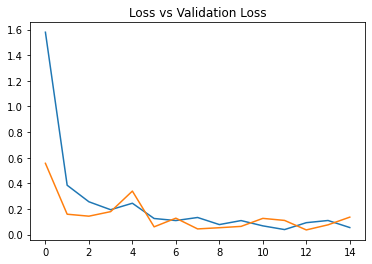

Text(0.5, 1.0, 'Accuracy vs Validation Accuracy')

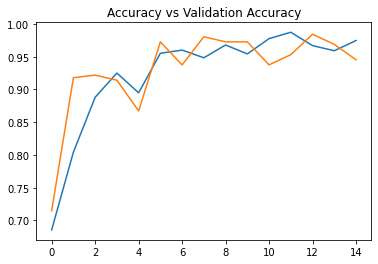

In [28]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Loss vs Validation Loss")

plt.show()

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Accuracy vs Validation Accuracy")